# Effect of Distributed PV and EV Charging on a Distribution Feeder
by Sunash Sharma and Zachary Lee

The purpose of this simulation is to evaluate the impact of an Adaptive Charging Networks and PV systems on a distribution feeder.

We use the Iowa Test Feeder provided by Iowa State University (http://wzy.ece.iastate.edu/Testsystem.html). The feeder is described in .dss files which can be used with OpenDSS. In addition to an accurate feeder model, this dataset also includes real smart-meter data with hourly resolution. 

For PV generation we use the SAM tool from NREL to generate a characteristic generation curve using a typical meteorological year (TMY) for Des Moines, Iowa.

For EV load, we use real data from the JPL ACN. 

We install EV charging and PV generation on a single bus in the Iowa Test Feeder and analyze the effects of doing so on grid health metrics; namely, the minimal per-unit voltage in the network. We analyze the metrics under different charging and generation conditions.

If you're running this notebook in a new environment (e.g. Google Colab), run the following cell to install the necessary dependencies.

In [3]:
!git clone https://github.com/zach401/acnportal.git

Cloning into 'acnportal'...
remote: Enumerating objects: 517, done.
remote: Counting objects: 100% (517/517), done.
remote: Compressing objects: 100% (263/263), done.
remote: Total 6537 (delta 370), reused 375 (delta 253), pack-reused 6020
Receiving objects: 100% (6537/6537), 3.51 MiB | 16.70 MiB/s, done.
Resolving deltas: 100% (4481/4481), done.


In [4]:
!git clone https://github.com/caltech-netlab/adacharge.git

Cloning into 'adacharge'...
remote: Enumerating objects: 379, done.
remote: Counting objects: 100% (379/379), done.
remote: Compressing objects: 100% (152/152), done.
remote: Total 379 (delta 243), reused 349 (delta 218), pack-reused 0
Receiving objects: 100% (379/379), 92.95 KiB | 1.86 MiB/s, done.
Resolving deltas: 100% (243/243), done.


In [5]:
!cd adacharge && git checkout py_3.6_compatibility

Branch 'py_3.6_compatibility' set up to track remote branch 'py_3.6_compatibility' from 'origin'.
Switched to a new branch 'py_3.6_compatibility'


In [6]:
!pip install acnportal/.
!pip install adacharge/.
!pip install Mosek
!pip install 'OpenDSSDirect.py[extras]'
!pip install tqdm

Processing ./acnportal
  Created wheel for acnportal: filename=acnportal-0.2.2-cp36-none-any.whl size=132646 sha256=4fff33f09b574f1abc4676ec7377a7ef13466529ebb6b6e471d2fb0d601bffb4
  Stored in directory: /tmp/pip-ephem-wheel-cache-7c4w5eh1/wheels/6d/6a/19/10aef74a8c705c23f53e3e1d696420b07fcdbc88af47701336
Successfully built acnportal
Processing ./adacharge
  Created wheel for adacharge: filename=adacharge-0.0.1-cp36-none-any.whl size=19538 sha256=fac68da02eb47c3516d3f69250ea28e7d5e4bb9b5e2d23910f88bf2b6198ef27
  Stored in directory: /tmp/pip-ephem-wheel-cache-o6p46k8b/wheels/81/51/ca/594c0e70cb3e97ed6cddde8f7b45b43527260c9bb945d7560f
Successfully built adacharge


In [7]:
!mkdir src/
!wget -P src/ https://raw.githubusercontent.com/caltech-netlab/acnportal-experiments/add_open_dss_experiment/examples/3-Grid-Impacts/3.2-Iowa-Feeder-with-EV-and-Solar-OpenDSS/src/__init__.py
!wget -P src/ https://raw.githubusercontent.com/caltech-netlab/acnportal-experiments/add_open_dss_experiment/examples/3-Grid-Impacts/3.2-Iowa-Feeder-with-EV-and-Solar-OpenDSS/src/acn_experiment.py
!wget -P src/ https://raw.githubusercontent.com/caltech-netlab/acnportal-experiments/add_open_dss_experiment/examples/3-Grid-Impacts/3.2-Iowa-Feeder-with-EV-and-Solar-OpenDSS/src/composite_experiment.py
!wget -P src/ https://raw.githubusercontent.com/caltech-netlab/acnportal-experiments/add_open_dss_experiment/examples/3-Grid-Impacts/3.2-Iowa-Feeder-with-EV-and-Solar-OpenDSS/src/opendss_experiment.py

!mkdir data/
!wget -P data/ https://raw.githubusercontent.com/caltech-netlab/acnportal-experiments/add_open_dss_experiment/examples/3-Grid-Impacts/3.2-Iowa-Feeder-with-EV-and-Solar-OpenDSS/data/results_des_moines_autosized_270kWdc.csv

!mkdir iowa_data/
!wget -P iowa_data/ https://raw.githubusercontent.com/caltech-netlab/acnportal-experiments/add_open_dss_experiment/examples/3-Grid-Impacts/3.2-Iowa-Feeder-with-EV-and-Solar-OpenDSS/iowa_data/Calculated%20Nodal%20P&Q.xlsx
!wget -P iowa_data/ https://raw.githubusercontent.com/caltech-netlab/acnportal-experiments/add_open_dss_experiment/examples/3-Grid-Impacts/3.2-Iowa-Feeder-with-EV-and-Solar-OpenDSS/iowa_data/Smart%20Meter%20Data.xlsx
!wget -P iowa_data/ https://raw.githubusercontent.com/caltech-netlab/acnportal-experiments/add_open_dss_experiment/examples/3-Grid-Impacts/3.2-Iowa-Feeder-with-EV-and-Solar-OpenDSS/iowa_data/Update%20History.txt
!wget -P iowa_data/ https://raw.githubusercontent.com/caltech-netlab/acnportal-experiments/add_open_dss_experiment/examples/3-Grid-Impacts/3.2-Iowa-Feeder-with-EV-and-Solar-OpenDSS/iowa_data/iowa_nodal_P.csv
!wget -P iowa_data/ https://raw.githubusercontent.com/caltech-netlab/acnportal-experiments/add_open_dss_experiment/examples/3-Grid-Impacts/3.2-Iowa-Feeder-with-EV-and-Solar-OpenDSS/iowa_data/iowa_nodal_Q.csv
!wget -P iowa_data/ https://raw.githubusercontent.com/caltech-netlab/acnportal-experiments/add_open_dss_experiment/examples/3-Grid-Impacts/3.2-Iowa-Feeder-with-EV-and-Solar-OpenDSS/iowa_data/mid_america_gdt_aug_7_2014.json
!wget -P iowa_data/ https://raw.githubusercontent.com/caltech-netlab/acnportal-experiments/add_open_dss_experiment/examples/3-Grid-Impacts/3.2-Iowa-Feeder-with-EV-and-Solar-OpenDSS/iowa_data/mid_america_get_aug_7_2014.json

!mkdir iowa_dist_feeder/
!wget -P iowa_dist_feeder/ https://raw.githubusercontent.com/caltech-netlab/acnportal-experiments/add_open_dss_experiment/examples/3-Grid-Impacts/3.2-Iowa-Feeder-with-EV-and-Solar-OpenDSS/iowa_dist_feeder/Buscoords.dss
!wget -P iowa_dist_feeder/ https://raw.githubusercontent.com/caltech-netlab/acnportal-experiments/add_open_dss_experiment/examples/3-Grid-Impacts/3.2-Iowa-Feeder-with-EV-and-Solar-OpenDSS/iowa_dist_feeder/Capacitor.dss
!wget -P iowa_dist_feeder/ https://raw.githubusercontent.com/caltech-netlab/acnportal-experiments/add_open_dss_experiment/examples/3-Grid-Impacts/3.2-Iowa-Feeder-with-EV-and-Solar-OpenDSS/iowa_dist_feeder/CircuitBreaker.dss
!wget -P iowa_dist_feeder/ https://raw.githubusercontent.com/caltech-netlab/acnportal-experiments/add_open_dss_experiment/examples/3-Grid-Impacts/3.2-Iowa-Feeder-with-EV-and-Solar-OpenDSS/iowa_dist_feeder/DistriTransformer.dss
!wget -P iowa_dist_feeder/ https://raw.githubusercontent.com/caltech-netlab/acnportal-experiments/add_open_dss_experiment/examples/3-Grid-Impacts/3.2-Iowa-Feeder-with-EV-and-Solar-OpenDSS/iowa_dist_feeder/Line.dss
!wget -P iowa_dist_feeder/ https://raw.githubusercontent.com/caltech-netlab/acnportal-experiments/add_open_dss_experiment/examples/3-Grid-Impacts/3.2-Iowa-Feeder-with-EV-and-Solar-OpenDSS/iowa_dist_feeder/Linecode.dss
!wget -P iowa_dist_feeder/ https://raw.githubusercontent.com/caltech-netlab/acnportal-experiments/add_open_dss_experiment/examples/3-Grid-Impacts/3.2-Iowa-Feeder-with-EV-and-Solar-OpenDSS/iowa_dist_feeder/Load.dss
!wget -P iowa_dist_feeder/ https://raw.githubusercontent.com/caltech-netlab/acnportal-experiments/add_open_dss_experiment/examples/3-Grid-Impacts/3.2-Iowa-Feeder-with-EV-and-Solar-OpenDSS/iowa_dist_feeder/Master.dss
!wget -P iowa_dist_feeder/ https://raw.githubusercontent.com/caltech-netlab/acnportal-experiments/add_open_dss_experiment/examples/3-Grid-Impacts/3.2-Iowa-Feeder-with-EV-and-Solar-OpenDSS/iowa_dist_feeder/RegControl.dss
!wget -P iowa_dist_feeder/ https://raw.githubusercontent.com/caltech-netlab/acnportal-experiments/add_open_dss_experiment/examples/3-Grid-Impacts/3.2-Iowa-Feeder-with-EV-and-Solar-OpenDSS/iowa_dist_feeder/SubTransformer.dss
!wget -P iowa_dist_feeder/ https://raw.githubusercontent.com/caltech-netlab/acnportal-experiments/add_open_dss_experiment/examples/3-Grid-Impacts/3.2-Iowa-Feeder-with-EV-and-Solar-OpenDSS/iowa_dist_feeder/UnbalancedLoad.dss
!wget -P iowa_dist_feeder/ https://raw.githubusercontent.com/caltech-netlab/acnportal-experiments/add_open_dss_experiment/examples/3-Grid-Impacts/3.2-Iowa-Feeder-with-EV-and-Solar-OpenDSS/iowa_dist_feeder/Update%20History.txt
!wget -P iowa_dist_feeder/ https://raw.githubusercontent.com/caltech-netlab/acnportal-experiments/add_open_dss_experiment/examples/3-Grid-Impacts/3.2-Iowa-Feeder-with-EV-and-Solar-OpenDSS/iowa_dist_feeder/Vsource.dss

mkdir: cannot create directory ‘src/’: File exists
--2020-12-15 01:52:41--  https://raw.githubusercontent.com/caltech-netlab/acnportal-experiments/add_open_dss_experiment/examples/3-Grid-Impacts/3.2-Iowa-Feeder-with-EV-and-Solar-OpenDSS/src/__init__.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 0 [text/plain]
Saving to: ‘src/__init__.py.3’

__init__.py.3           [ <=>                ]       0  --.-KB/s    in 0s      

2020-12-15 01:52:41 (0.00 B/s) - ‘src/__init__.py.3’ saved [0/0]

--2020-12-15 01:52:41--  https://raw.githubusercontent.com/caltech-netlab/acnportal-experiments/add_open_dss_experiment/examples/3-Grid-Impacts/3.2-Iowa-Feeder-with-EV-and-Solar-OpenDSS/src/acn_experiment.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pytz
from datetime import datetime, date, timedelta
from datetime import timedelta
from copy import deepcopy
from tqdm import tqdm

import opendssdirect as dss

from acnportal import acnsim
from acnportal import algorithms

# from adacharge import *

import sys
sys.path.append("src/")
from importlib import reload
# noinspection PyUnresolvedReferences
import composite_experiment
reload(composite_experiment)
# noinspection PyUnresolvedReferences
from composite_experiment import ACNOpenDSSCompositeExperiment


First, we look at the maximum and minimum voltages in the Iowa Test Feeder
without any added ACNs or solar. We'll try two configurations; one with
transformer voltage regulation and one without. We run each scenario for 24
hours, starting on September 5, 2017. As data from all years is not available,
the JPL ACN usage profile is from the same date in 2019, and the solar usage
profile is from said date in 2014. September 5th was a weekday in both 2019 and
2017.

In the following code, we use an ACNOpenDSSCompositeExperiment class that wraps
an OpenDSS experiment with optional additional ACN loads or solar generation
added to the feeder. You can view the documentation for this class in the src
directory.

In [9]:
# Set default OpenDSS experiment configs.
open_dss_experiment_config = {
    "start": datetime(2017, 9, 5),
    "horizon": 24 * 60,
    "period": 5,
    "reg_control": True,
}

open_dss_experiment_config_without_reg = {
    "start": datetime(2017, 9, 5),
    "horizon": 24 * 60,
    "period": 5,
    "reg_control": False,
}

In [10]:
baseline_model = ACNOpenDSSCompositeExperiment(open_dss_experiment_config)
baseline_model.run_dss()

100%|██████████| 288/288 [00:30<00:00,  9.40it/s]


In [11]:
baseline_model_no_reg = ACNOpenDSSCompositeExperiment(open_dss_experiment_config_without_reg)
baseline_model_no_reg.run_dss()

100%|██████████| 288/288 [00:29<00:00,  9.84it/s]


Now that we've run the experiments, let's plot the minimum and maximum voltages
at baseline for each case, with and without regulation. The 1.05 and 0.95 p.u.
voltage deviation limits are also shown on the plot.

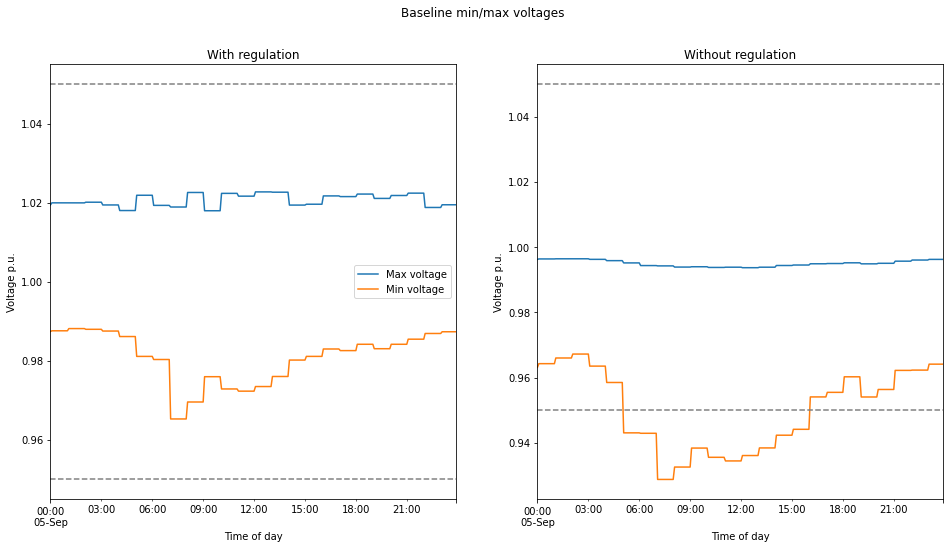

In [12]:
fig, ax = plt.subplots(1, 2, figsize=(16, 8), sharex=True)
baseline_model.plot_dss_voltages(ax=ax[0], legend=True, title="With regulation")
baseline_model_no_reg.plot_dss_voltages(ax=ax[1], title="Without regulation")
fig.suptitle("Baseline min/max voltages");

Without voltage regulation this feeder experiences significant under-voltage issues. Because of this, we will constrain the rest of the experiments to the case with voltage regulation, as this is more realistic.

## Adding an adaptive charging network (ACN)

### Uncontrolled charging
Now, let's add one JPL ACN, with usage according to September 5, 2019 to node 2053 of the Iowa Feeder. This node's transformer has capacity 225 kVa, so large-scale EV charging may conceivably be added to this site, especially if scheduled charging is used to avoid overloading the transformer. However, let's first run a simple uncontrolled charging scenario, in which each EV is allowed to charge at its maximum rate. The configuration for such an experiment is below. We first specify ACN configurations that are unchanged throughout our experiments, and then set an algorithm for each experiment.

In [13]:
acn_base_experiment_configs = {"2053": {
    "site": "jpl",
    "start": datetime(2019, 9, 5),
    "end": datetime(2019, 9, 6),
    "alg_name": None,
    "tariff_name": "sce_tou_ev_4_march_2019",
    "external_load": baseline_model.open_dss_experiment.P["load_2053"].to_numpy(),
    "external_load_name": "load_2053_20170905",
    "bus_transformer_cap": 225,
}}

In [14]:
# Set ACN-Sim Experiment Algorithm.
acn_unctrl_configs = deepcopy(acn_base_experiment_configs)
for config in acn_unctrl_configs.values():
    config["alg_name"] = "unctrl"

# Build composite experiment.
unctrl_2053 = ACNOpenDSSCompositeExperiment(
    open_dss_experiment_config, 
    acn_unctrl_configs,
)

In [15]:
# Run ACN-Sim Experiment
unctrl_2053.run_acn()

# Add EV load to the OpenDSS Experiment 
unctrl_2053.add_acn_loads()

In [16]:
# Run OpenDSS Experiment
unctrl_2053.run_dss(detailed_metrics=True)

100%|██████████| 288/288 [00:31<00:00,  9.26it/s]


Let's see the effects of adding an uncontrolled ACN to the grid on the voltage
bounds.

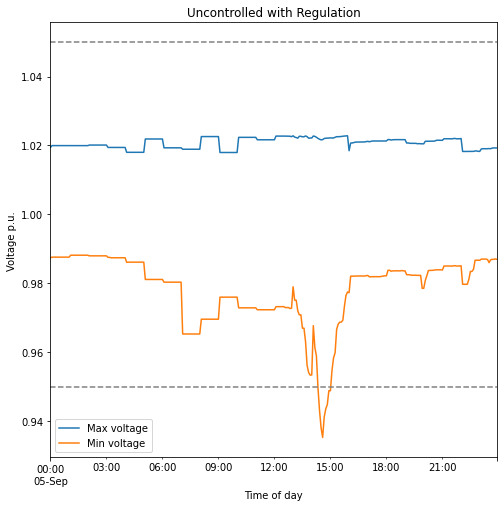

In [17]:
fig, ax = plt.subplots(figsize=(8, 8), sharex=True)
unctrl_2053.plot_dss_voltages(ax, legend=True, title="Uncontrolled with Regulation")

In [18]:
pd.concat(pd.DataFrame(val) for val in unctrl_2053.open_dss_experiment._overload_dict.values())[" %Normal"].groupby("Element").describe()

,count,mean,std,min,25%,50%,75%,max
Element,,,,,,,,
Transformer.T_2053,20.0,128.045,17.488356,100.1,116.0,125.2,137.3,160.7


Adding an uncontrolled JPL ACN to node 2053 of the feeder causes large under-
voltage issues and transformer overlaod (up to 245% overuse).
Clearly, if we wish to add such an ACN without installing
new electrical infrastructure, we must schedule charging in some way
that is reactive to the already-existing demands of the system.

### Load flattening

One way to respond to the demand of the loads already at node 2053 is to
schedule EV charging such that the total load at the node is flattened. We use
a model predictive control algorithm with a primary objective of charging all
EVs and a secondary objective of flattening the total load on the node. For
example, this algorithm will avoid charging EVs when external load at 2053 is
high, and will charge EVs more when external load is low, such that the total
load is pushed towards 0. Additionally, the MPC framework allows for the sum of
external load and EV load to be limited by the transformer capacity of 225,
which we enforce to ensure the control parameters are reasonable.
Let's see if scheduling charging in this manner
decreases the undervoltage issue we observed for uncontrolled charging.

For this experiment, we will need more than 288 periods of baseline load
data, as the ACN experiment runs for longer. So, we first run the baseline 
scenario over a longer horizon.

In [19]:
longer_open_dss_experiment_config = deepcopy(open_dss_experiment_config)
longer_open_dss_experiment_config["horizon"] *= 2
longer_baseline = ACNOpenDSSCompositeExperiment(
    longer_open_dss_experiment_config
)
longer_baseline.run_dss()

100%|██████████| 576/576 [01:03<00:00,  9.02it/s]


In [20]:
# Set ACN-Sim Experiment Algorithm.
acn_load_flattening_configs = deepcopy(acn_base_experiment_configs)
for config in acn_load_flattening_configs.values():
    config["alg_name"] = "load_flattening"
    config["external_load"] = longer_baseline.open_dss_experiment.P["load_2053"].to_numpy()

# Build composite experiment.
load_flattening_2053 = ACNOpenDSSCompositeExperiment(
    open_dss_experiment_config, 
    acn_load_flattening_configs
)

In [21]:
# Run ACN-Sim Experiment
load_flattening_2053.run_acn()

# Add EV load to the OpenDSS Experiment 
load_flattening_2053.add_acn_loads()

ECOS
Plugin Event...
Unplug Event...
Plugin Event...
Plugin Event...
Plugin Event...
Plugin Event...
Plugin Event...
Plugin Event...
Plugin Event...
Plugin Event...
Plugin Event...
Plugin Event...
Plugin Event...
Plugin Event...
Plugin Event...
Plugin Event...
Plugin Event...
Plugin Event...
Plugin Event...
Plugin Event...
Plugin Event...
Plugin Event...
Plugin Event...
Plugin Event...
Plugin Event...
Plugin Event...
Plugin Event...
Plugin Event...
Plugin Event...
Plugin Event...
Plugin Event...
Plugin Event...
Plugin Event...
Plugin Event...
Plugin Event...
Plugin Event...
Plugin Event...
Plugin Event...
Plugin Event...
Plugin Event...
Plugin Event...
Plugin Event...
Plugin Event...
Plugin Event...
Plugin Event...
Plugin Event...
Plugin Event...
Plugin Event...
Plugin Event...
Plugin Event...
Plugin Event...
Plugin Event...
Plugin Event...
Unplug Event...
Unplug Event...
Unplug Event...
Plugin Event...
Plugin Event...
Plugin Event...
Unplug Event...
Plugin Event...
Unplug Event...
Plu

/usr/local/lib/python3.6/dist-packages/acnportal/acnsim/simulator.py:394: UserWarning: Not serializing signals as value typesare not natively JSON serializable.
  UserWarning,


In [22]:
# Run OpenDSS Experiment
load_flattening_2053.run_dss(detailed_metrics=True)

100%|██████████| 288/288 [00:31<00:00,  9.16it/s]


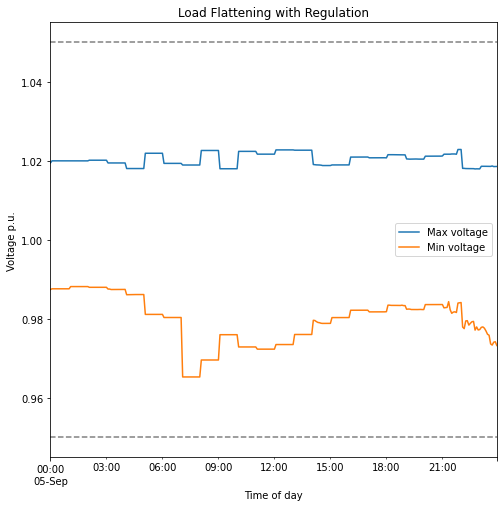

In [23]:
fig, ax = plt.subplots(figsize=(8, 8), sharex=True)
load_flattening_2053.plot_dss_voltages(ax, legend=True, title="Load Flattening with Regulation")

In [27]:
pd.concat(pd.DataFrame(val) for val in load_flattening_2053.open_dss_experiment._overload_dict.values())[" %Normal"]

Series([], Name:  %Normal, dtype: object)

(The empty series means there were no transformer overloads)

We see that the minimum voltage profile still contains a dip later in the day,
which is due to the load flattening algorithm increasing the aggregate charging
rate to meet the additional demand caused by EV arrivals later in the day. With
this algorithm, we don't have the same under voltage issues we had with
uncontrolled charging.

## Solar Data

We load solar data taken from NREL's System Advior Model (SAM) 
(https://sam.nrel.gov/). The data is for a 270 kW DC solar array on Sept 5,
2014 in Iowa, using default SAM parameters. 270 kW DC was chosen because it
corresponds to just below 225 kW AC at a 1.22 ratio, allowing for use with a
225 kVA transformer on bus 2053 of the feeder.

In [28]:
pv_year = 2014
pv_data = pd.read_csv("data/results_des_moines_autosized_270kWdc.csv")
pv_data["Time stamp"] = [f"{pv_year} {ts}" for ts in pv_data["Time stamp"]]
pv_data["Time stamp"] = pd.to_datetime(pv_data["Time stamp"])
pv_data = pv_data.set_index("Time stamp")
# Rescale PV generation to AC capacity, and follow consumer-perspective sign convention (negative for generation)
pv_data["AC Power | (kW)"] = -1 * pv_data["Array DC power | (kW)"] / 1.22
pv_data = pv_data.resample("5T").ffill()
trunc_gen = pv_data.loc[datetime(pv_year, 9, 5):]["AC Power | (kW)"].to_numpy()
external_load_2053 = longer_baseline.open_dss_experiment.P["load_2053"].to_numpy()
external_load_and_gen_2053 = external_load_2053 + trunc_gen[:len(external_load_2053)]
solar_gen = trunc_gen[:len(external_load_2053)]

In [29]:
# Set default ACN-Sim experiment configs.
acn_solar_experiment_configs = {"2053": {
    "site": "jpl",
    "start": datetime(2019, 9, 5),
    "end": datetime(2019, 9, 6),
    "alg_name": None,
    "tariff_name": "sce_tou_ev_4_march_2019",
    "external_load": external_load_and_gen_2053,
    "external_load_name": "load_gen_2053_20170905",
    "bus_transformer_cap": 225,
}}

In [30]:
# Set ACN-Sim Experiment Algorithm.
acn_solar_load_flattening_configs = deepcopy(acn_solar_experiment_configs)
for config in acn_solar_load_flattening_configs.values():
    config["alg_name"] = "load_flattening"

# Build composite experiment.
solar_load_flattening_2053 = ACNOpenDSSCompositeExperiment(
    open_dss_experiment_config, 
    acn_solar_load_flattening_configs, 
)


In [31]:
# Run ACN-Sim Experiment
solar_load_flattening_2053.run_acn()

# Add EV load to the OpenDSS Experiment 
solar_load_flattening_2053.add_acn_loads()

# Add solar load to the OpenDSS Experiment
solar_load_flattening_2053.add_general_loads(solar_gen)

ECOS
Plugin Event...
Unplug Event...
Plugin Event...
Plugin Event...
Plugin Event...
Plugin Event...
Plugin Event...
Plugin Event...
Plugin Event...
Plugin Event...
Plugin Event...
Plugin Event...
Plugin Event...
Plugin Event...
Plugin Event...
Plugin Event...
Plugin Event...
Plugin Event...
Plugin Event...
Plugin Event...
Plugin Event...
Plugin Event...
Plugin Event...
Plugin Event...
Plugin Event...
Plugin Event...
Plugin Event...
Plugin Event...
Plugin Event...
Plugin Event...
Plugin Event...
Plugin Event...
Plugin Event...
Plugin Event...
Plugin Event...
Plugin Event...
Plugin Event...
Plugin Event...
Plugin Event...
Plugin Event...
Plugin Event...
Plugin Event...
Plugin Event...
Plugin Event...
Plugin Event...
Plugin Event...
Plugin Event...
Plugin Event...
Plugin Event...
Plugin Event...
Plugin Event...
Plugin Event...
Plugin Event...
Unplug Event...
Unplug Event...
Unplug Event...
Plugin Event...
Plugin Event...
Plugin Event...
Unplug Event...
Plugin Event...
Unplug Event...
Plu

/usr/local/lib/python3.6/dist-packages/acnportal/acnsim/simulator.py:394: UserWarning: Not serializing signals as value typesare not natively JSON serializable.
  UserWarning,


In [32]:
# Run OpenDSS Experiment
solar_load_flattening_2053.run_dss(detailed_metrics=True)

100%|██████████| 288/288 [00:31<00:00,  9.02it/s]


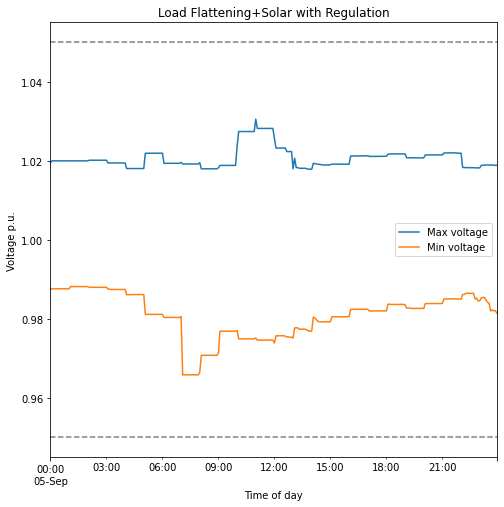

In [33]:
fig, ax = plt.subplots(figsize=(8, 8), sharex=True)
solar_load_flattening_2053.plot_dss_voltages(ax, legend=True, title="Load Flattening+Solar with Regulation")

In [34]:
pd.concat(pd.DataFrame(val) for val in solar_load_flattening_2053.open_dss_experiment._overload_dict.values())[" %Normal"]

Series([], Name:  %Normal, dtype: object)

(The empty series means there were no transformer overloads)

We see that the minimum and maximum voltage profiles look very similar to the
baseline profiles. The interpretation of this is twofold: first, adding the one
solar array to the feeder does not cause an over-voltage issue in the grid.
Second, load flattening against solar (i.e. charging EVs when solar is more
available) eliminates any under-voltage issues from the ACN; moreover, solar
and load flattening essentially eliminates any effect of the ACN on the minimal
voltage.

The plot below shows the under-voltage deviations from all scenarios together.
Note that the curves for the baseline and load flattening + solar
under-voltages are essentially co-located. With solar, we can make it so that
the ACN has no effect on upper and lower voltage bounds of the entire grid.

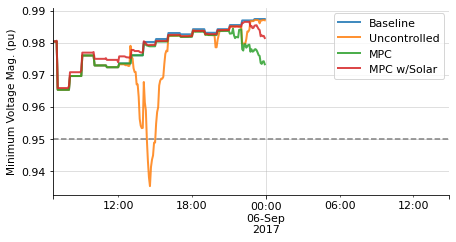

In [37]:
fig, ax = plt.subplots(sharex=True)
style = {
    "linewidth": 2,
    "alpha": .85,
}
baseline_model.open_dss_experiment.voltage_pu.min().plot(**style)
unctrl_2053.open_dss_experiment.voltage_pu.min().plot(**style)
load_flattening_2053.open_dss_experiment.voltage_pu.min().plot(**style)
solar_load_flattening_2053.open_dss_experiment.voltage_pu.min().plot(**style)
ax.set_ylabel("Minimum Voltage Mag. (pu)", fontsize=10.5)
ax.legend(["Baseline", "Uncontrolled", "MPC", "MPC w/Solar"])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.xlim((25076560.0, 25078495.0))
ax.axhline(0.95, linestyle="--", color="grey")
plt.rc('text', usetex=False)
plt.rcParams.update({'font.size': 11})
ax.grid(alpha=0.5)
ax.grid(alpha=0.5)
fig = plt.gcf()
fig.set_size_inches(6.47, 3.5)
plt.tight_layout()

Let's check the energy delivered for each scenario with an ACN.

In [36]:
unctrl_energy_delivered = acnsim.proportion_of_energy_delivered(
    unctrl_2053.acn_experiments["2053"].sim
)
load_flattening_energy_delivered = acnsim.proportion_of_energy_delivered(
    load_flattening_2053.acn_experiments["2053"].sim
)
solar_load_flattening_energy_delivered = acnsim.proportion_of_energy_delivered(
    solar_load_flattening_2053.acn_experiments["2053"].sim
)
print(
    f"Energy delivered with Uncontrolled Charging: "
    f"{unctrl_energy_delivered}\n"
    f"Energy delivered with Load Flattening: "
    f"{load_flattening_energy_delivered}\n"
    f"Energy delivered with Load Flattening and Solar: "
    f"{solar_load_flattening_energy_delivered}\n"
)

Energy delivered with Uncontrolled Charging: 1.0
Energy delivered with Load Flattening: 0.999073630050463
Energy delivered with Load Flattening and Solar: 0.9993695691513583

